In [ ]:
!unzip /content/drive/MyDrive/Datasets/colorization.zip -d /content/colorization_dataset

In [30]:
import os
import torch #tools for building and training neural networks
import torchvision #prebuild datasets,  models , architectures and image transformations
from torchvision.io import read_image #helps to read images from files and convert them to tensors
from torch import nn #provides a vast variety of prebuild layers and functions for building our architecture
from torch.utils.data import Dataset, DataLoader, random_split #gives convinent tools for handling datasets  and creating dataloaders for efficient data loadiing and splitting data into training and testing
from torchvision.datasets import ImageFolder # enables us to easliy load datasets organised in specific folder structure
import torch.optim as optim #provides various optimization algorithms like SGD adam
import torchvision.transforms as transforms #gives access to wide range of image transformations that we ca apply to out dataset like resizing croping and normalization
import matplotlib.pyplot as plt
from PIL import Image #provides functionality to handle images
from tqdm.notebook import tqdm #provides progress bar while training the model

In [31]:
#Paramaters
MANUAL_SEED = 42 #we will get same result making it easy t0 debug
BATCH_SIZE = 32 #Number of images processed during each iteration in training
SHUFFLE = True # dataloader will shuffle the dataset during training


In [32]:
#Creating a custom dataset class to load and process oru images
class LandScapeDataset(Dataset):
  def __init__(self,transform=None): #Initilizing the dataset in the constructor method
    #Specifying the root directory of images
    self.dataroot_dir = '/content/colorization_dataset/landscape Images'
    #listing the images present in the colour subdirectoruy
    self.images = os.listdir(f'{self.dataroot_dir}/color')
    #providing and optional transform argument
    self.transform = transform

  def __len__(self): #returns the total number of images in the dataset i.e the length of the dataset
    return len(self.images)
    #it helps to determine the size of the dataset and set up our dataloader accordingly

  def __getitem__(self,idx): #responsible for retriving a specific image and its corresponding grayscale counter part at the given index as idx
    #Get image Paths
    img_path= self.images[idx]

    #load the images
    color_image = read_image(f'{self.dataroot_dir}/color/{img_path}') / 255
    gray_imge = read_image(f'{self.dataroot_dir}/gray/{img_path}') / 255
    #255  is used for normilization of the dataset

    if(self.transform): #If a transformation is specified then apply it to both the images
      color_image = self.transform(color_image)
      gray_imge = self.transform(gray_imge)
    #finally return the color images and grayscale images as a tuple
      return  color_image,gray_imge


In [33]:
#Defining hte transformation pipeline
transform = transforms.Compose([transforms.Resize((150,150),
                                antialias=True)])
#Appling the transformation to images while loading
dataset = LandScapeDataset(transform = transform)
#Splittin the dataset into trainng and testing data
train_set , test_set = random_split(dataset,[0.8,0.2],generator=torch.Generator().manual_seed(MANUAL_SEED))

#load the train and test data
#this dataloader will iterate over the training set in the batches of provided size
trainloader = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=SHUFFLE)
#creating a similar dataloader for testsets
testloader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)




In [34]:
#Visualizing the images
def show_images(color,grey):
  fig, axs = plt.subplots(5,2,figsize=(15,15))
  axs[0,0].set_title('Grayscale Images')
  axs[0,1].set_title('Color Images')
  for i in range(5):
    axs[i,0].imshow(gray[i].permute(1,2,0),cmap='gray')
    axs[i,0].axis('off')
    axs[i,1].imshow(color[i].permute(1,2,0))
    axs[i,1].axis('off')
  plt.show()

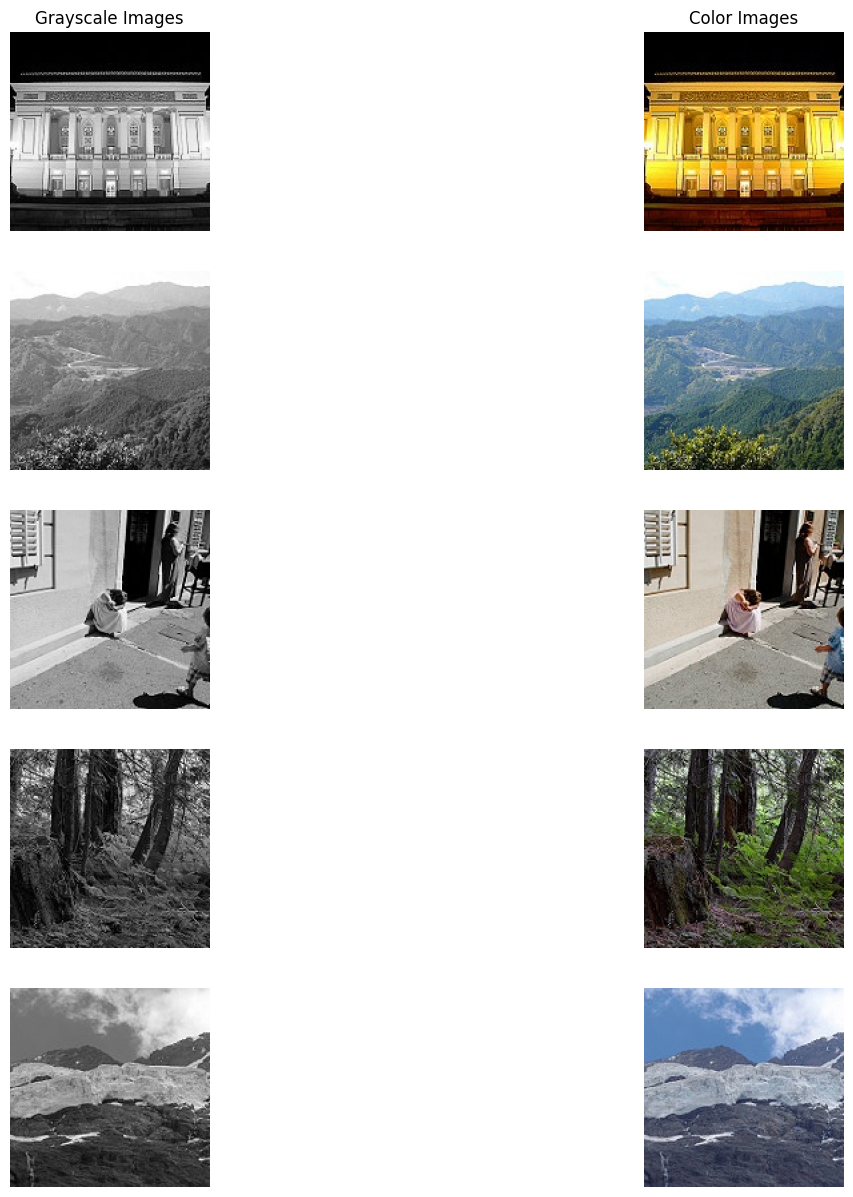

In [35]:
color,gray = next(iter(trainloader))
show_images(color,gray)

In [36]:
#Training Variables

EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9 #helps accelerate conversion and helps overcome local optima
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'



In [37]:
#Define the autoencoder model that will convert the greyscale image to color
class ColorAutoEncoder(nn.Module):
  #Defines the colourautoencoder class which is a subclass of nn.module from pytorch .
  #It implements the autoencoder architecture using a combination of convolution and transpose convolution layers
  def __init__(self):
    super().__init__()
    #Input shape : Bx1x150x150
    #Conv2D(in_channels, out_channels,Kernal_size, stride , padding)

    self.down1 = nn.Conv2d(1,64,3,stride=2)
    self.down2 = nn.Conv2d(64,128,3,stride=2,padding=1)
    self.down3 = nn.Conv2d(128,256,3,stride=2,padding=1)
    self.down4 = nn.Conv2d(256,512,3,stride=2,padding=1)
    #this model has sverla nn.Conv2D layers for downsampling that represent our encoder and nn.Conv2d lyer for unsampling that reprsent out decoder
    #this layers progressivey reduce and then incerase the special dimension of the  input image to perform the colorization task
    self.up1=nn.ConvTranspose2d(512,256,3,stride=2,padding=1)
    self.up2=nn.ConvTranspose2d(512,128,3,stride=2,padding=1)
    self.up3=nn.ConvTranspose2d(256,64,3,stride=2,padding=1,output_padding=1)
    self.up4=nn.ConvTranspose2d(128,3,3,stride=2,output_padding=1)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  #the forward method defines the forward pass of the method
  #It takes the input x and passes it throug the layers of the autoencoders
  #applying relu activation function to introduce non-linearlity an densure output values within the desired range
  def forward(self,x):
    #Encoder
    d1 = self.relu(self.down1(x))
    d2 = self.relu(self.down2(d1))
    d3 = self.relu(self.down3(d2))
    d4 = self.relu(self.down4(d3))
    #Upsampling
    u1 = self.relu(self.up1(d4))
    u2 = self.relu(self.up2(torch.cat((u1,d3),dim=1)))
    u3 = self.relu(self.up3(torch.cat((u2,d2),dim=1)))
    u4 = self.sigmoid(self.up4(torch.cat((u3,d1),dim=1)))

    return u4


In [38]:
#creatin the instance of the autoencoder model and moving it to the specified device using the .todevice method
model = ColorAutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) #calculates the total number of parramaters
print(f"Total number of parameters in the model: {total_params}:")

Total number of parameters in the model: 3470659:


In [39]:
#defining the loss function and initilizing the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)



In [40]:
#define the training loop
#Iterating over the specified number of epochs
for epoch in range(EPOCHS):
  running_loss = 0.0 #initilizing the running loss variable for each epoch to keep the trach of the cumulative loss during the epoch
  for idx,(color_img,gray_img) in tqdm(enumerate(trainloader),total=len(trainloader)):#within each epoch we load the training data using enumerate trainloader
    #move the images to the specified device
    color_img = color_img.to(DEVICE)
    gray_img = gray_img.to(DEVICE)

    #Maka predictions by passing the grayscale image through the model
    predictions = model(gray_img)

    #setting the gradient to zero using gradient to zero_grad() to avoid accumulation of previous iterations
    optimizer.zero_grad()

    #calculating the loss between the predicted colour image and actual colour image
    loss = criterion(color_img,predictions)

    #calculate gradients and back propogate. the gradients are computed with loss.backward
    loss.backward()
    #The optimizer performs a paramater update with optimiser.step
    optimizer.step()

    #accumulate the loss for the current batch i.e the loss value is added to the running loss
    running_loss += loss.item()

    #After each epoch we print the epoch number and the average runnin gloss
  print(f'Epoch:{epoch+1},Loss:{running_loss:.6f}')
print("Training Finished")

  0%|          | 0/179 [00:00<?, ?it/s]

Epoch:1,Loss:3.582433


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch:2,Loss:1.769691


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch:3,Loss:1.511034


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch:4,Loss:1.394323


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch:5,Loss:1.348315


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch:6,Loss:1.309274


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch:7,Loss:1.254294


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch:8,Loss:1.242058


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch:9,Loss:1.235251


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch:10,Loss:1.217449
Training Finished


In [42]:
#Testing our model on the test data
total_loss = 0.0
#in this code we iterate over the testin gdata using the for loop
with torch.no_grad():
  for idx,(color_img,gray_img) in tqdm(enumerate(testloader),total=len(testloader)):
    #we move the colour and greyscaled image to the specified device
    color_img = color_img.to(DEVICE)
    gray_img = gray_img.to(DEVICE)
    #We make the predictions using the trained model
    predictions = model(gray_img)
    #Calculate the loss between the predicted colour images and the real images
    loss = criterion(predictions,color_img)
    #the loss value is accumulated in the total loss variable
    total_loss += loss.item()
  #we print the avg testing loss by diving the total testing loss by the number of batches in the testing data
  print(f'Total Test Loss is: {total_loss/len(testloader):.3f}')

  0%|          | 0/45 [00:00<?, ?it/s]

Total Test Loss is: 0.007


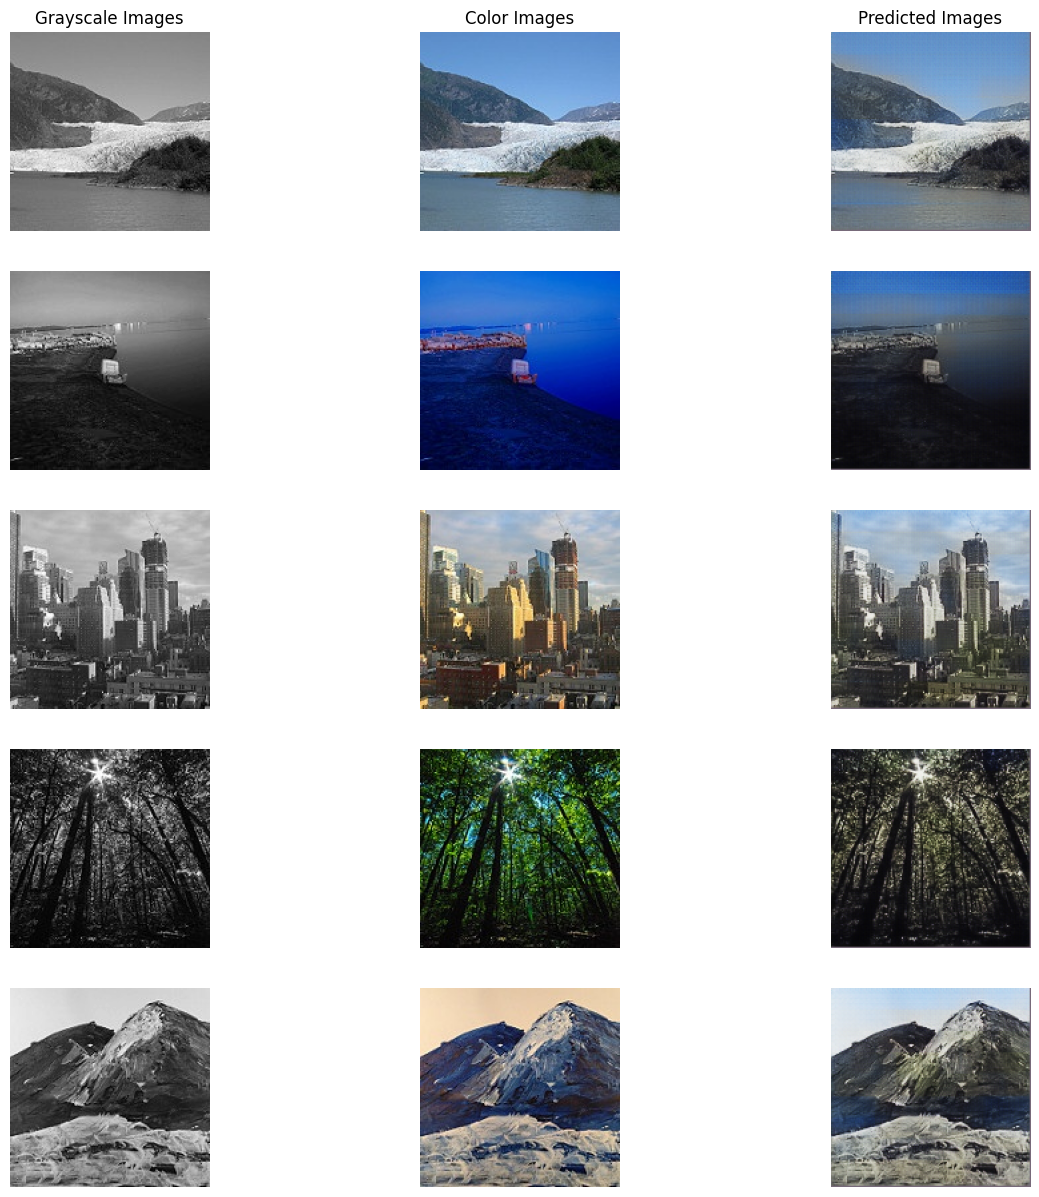

In [48]:
def show_predictions(color, gray, predictions):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale Images')
    axs[0, 1].set_title('Color Images')
    axs[0, 2].set_title('Predicted Images')

    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].cpu().permute(1, 2, 0), cmap='gray')  # Move to CPU
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].cpu().permute(1, 2, 0))  # Move to CPU
        axs[i, 2].axis('off')
        axs[i, 2].imshow(predictions[i].cpu().permute(1, 2, 0))  # Move to CPU

    plt.show()

show_predictions(color_img, gray_img, predictions)


In [50]:
model_path = '/content/drive/MyDrive/models/BlacknWhite-to-color-image-using-autoencoders.pth'
torch.save(model.state_dict(), model_path)

<ipython-input-81-74ed47093683>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/models/BlacknWhite-to-color-image-u

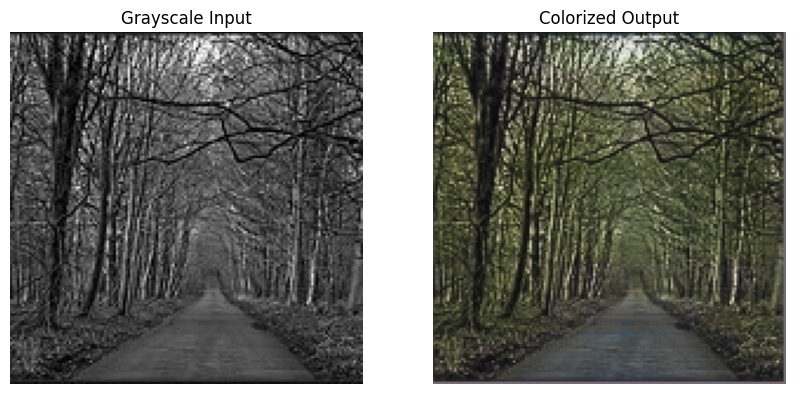

In [81]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the model and set it to evaluation mode
model = ColorAutoEncoder().to(DEVICE)
model.load_state_dict(torch.load('/content/drive/MyDrive/models/BlacknWhite-to-color-image-using-autoencoders.pth'))
model.eval()

# Define a transform for resizing and normalizing grayscale image
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

def colorize_image(input_image_path):
    # Load the grayscale image, preprocess, and add batch dimension
    img = Image.open(input_image_path).convert("L")  # Ensure it's grayscale
    img = transform(img).unsqueeze(0).to(DEVICE)  # Shape: [1, 1, 150, 150]

    # Pass the image through the model to get the colorized version
    with torch.no_grad():
        prediction = model(img).squeeze(0).cpu()  # Shape: [3, 150, 150]

    # Display the original grayscale and the colorized image
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img.squeeze().cpu(), cmap='gray')
    axs[0].set_title("Grayscale Input")
    axs[0].axis("off")

    axs[1].imshow(prediction.permute(1, 2, 0))  # Rearrange dimensions to HxWxC
    axs[1].set_title("Colorized Output")
    axs[1].axis("off")
    plt.show()

# Path to user-provided grayscale image
user_image_path = "/content/colorization_dataset/landscape Images/gray/5565.jpg"  # replace with your file path
colorize_image(user_image_path)


<ipython-input-82-9854b727a19f>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/models/BlacknWhite-to-color-image-u

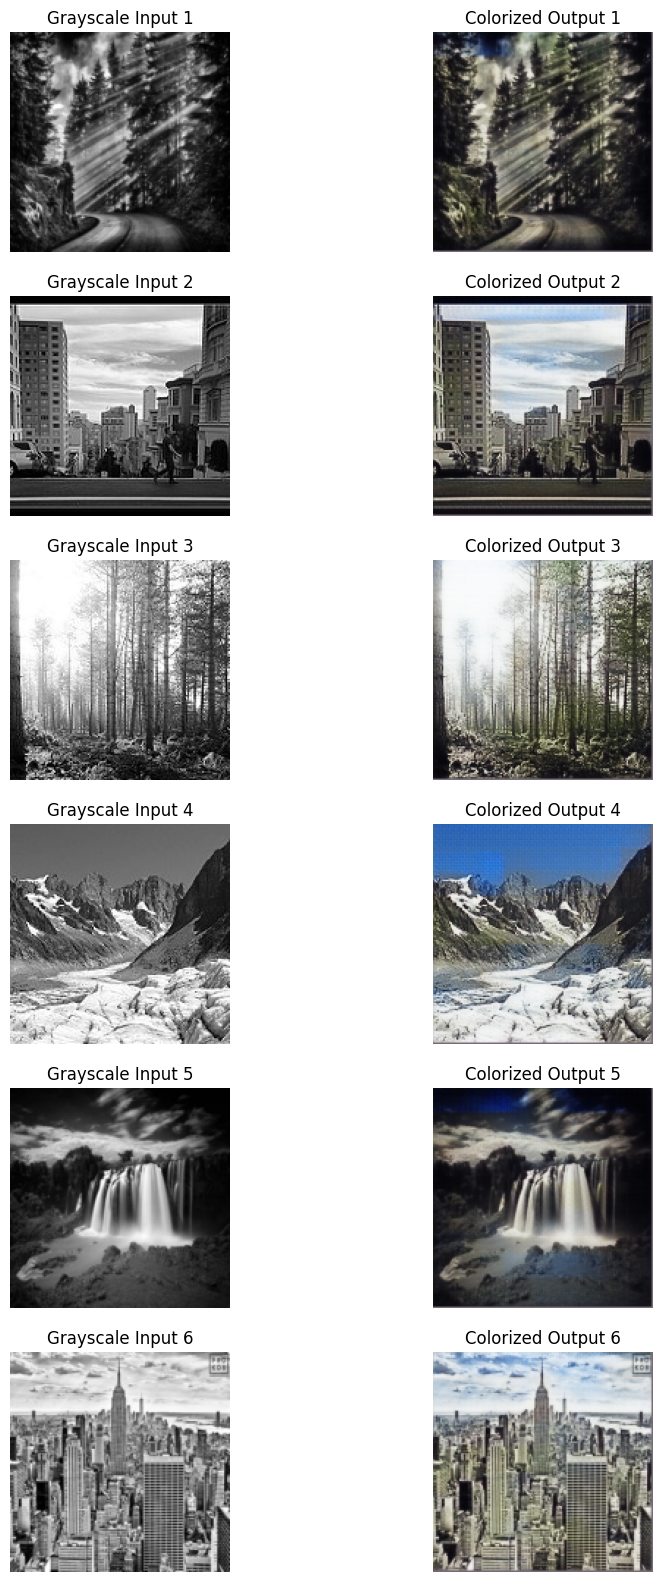

In [82]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the model and set it to evaluation mode
model = ColorAutoEncoder().to(DEVICE)
model.load_state_dict(torch.load('/content/drive/MyDrive/models/BlacknWhite-to-color-image-using-autoencoders.pth'))
model.eval()

# Define a transform for resizing and normalizing grayscale images
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

def colorize_images(image_paths):
    # Load and preprocess the images
    images = []
    for path in image_paths:
        img = Image.open(path).convert("L")  # Ensure grayscale
        img = transform(img)  # Resize and normalize
        images.append(img)

    # Stack images to form a batch and move to DEVICE
    images = torch.stack(images).to(DEVICE)  # Shape: [5, 1, 150, 150]

    # Generate colorized predictions
    with torch.no_grad():
        predictions = model(images)  # Shape: [5, 3, 150, 150]

    # Display each grayscale input with its colorized prediction
    fig, axs = plt.subplots(6, 2, figsize=(10, 20))  # 5 rows, 2 columns

    for i in range(6):
        # Show grayscale image
        axs[i, 0].imshow(images[i].squeeze().cpu(), cmap='gray')
        axs[i, 0].set_title(f"Grayscale Input {i+1}")
        axs[i, 0].axis("off")

        # Show colorized prediction
        axs[i, 1].imshow(predictions[i].cpu().permute(1, 2, 0))  # Rearrange to HxWxC
        axs[i, 1].set_title(f"Colorized Output {i+1}")
        axs[i, 1].axis("off")

    plt.show()

# Paths to 5 user-provided grayscale images
user_image_paths = [
    "/content/bwimage.jpeg",
    "/content/colorization_dataset/landscape Images/gray/5552.jpg",
    "/content/colorization_dataset/landscape Images/gray/5556.jpg",
    "/content/colorization_dataset/landscape Images/gray/5558.jpg",
    "/content/bwimage1.jpeg",
    "/content/bw3.jpeg"
]  # Replace with actual paths

colorize_images(user_image_paths)
